<a href="https://colab.research.google.com/github/syamkakarla98/Satellite_Imagery_Analysis/blob/main/Classification/Land_Cover_Classification_in_Satellite_Imagery_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='tomato'>Land Cover Classification in Satellite Imagery using Python</font>

In [ ]:
!pip install earthpy gdal

# Import Modules

In [ ]:
!pip install scikit-learn-intelex

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%cd /tmp/shared


/tmp/shared


# Read Data

In [3]:
from glob import glob
S_sentinel_bands = glob("/tmp/shared/dataset22/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B01_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B02_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B03_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B04_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B05_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B06_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B07_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B08_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B09_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B11_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B12_(Raw).tiff',
 '/tmp/sha

In [4]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))


In [5]:
arr_st = np.stack(l)

In [6]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 469
Width: 767
Bands: 12


# Visualize Data

## Bands

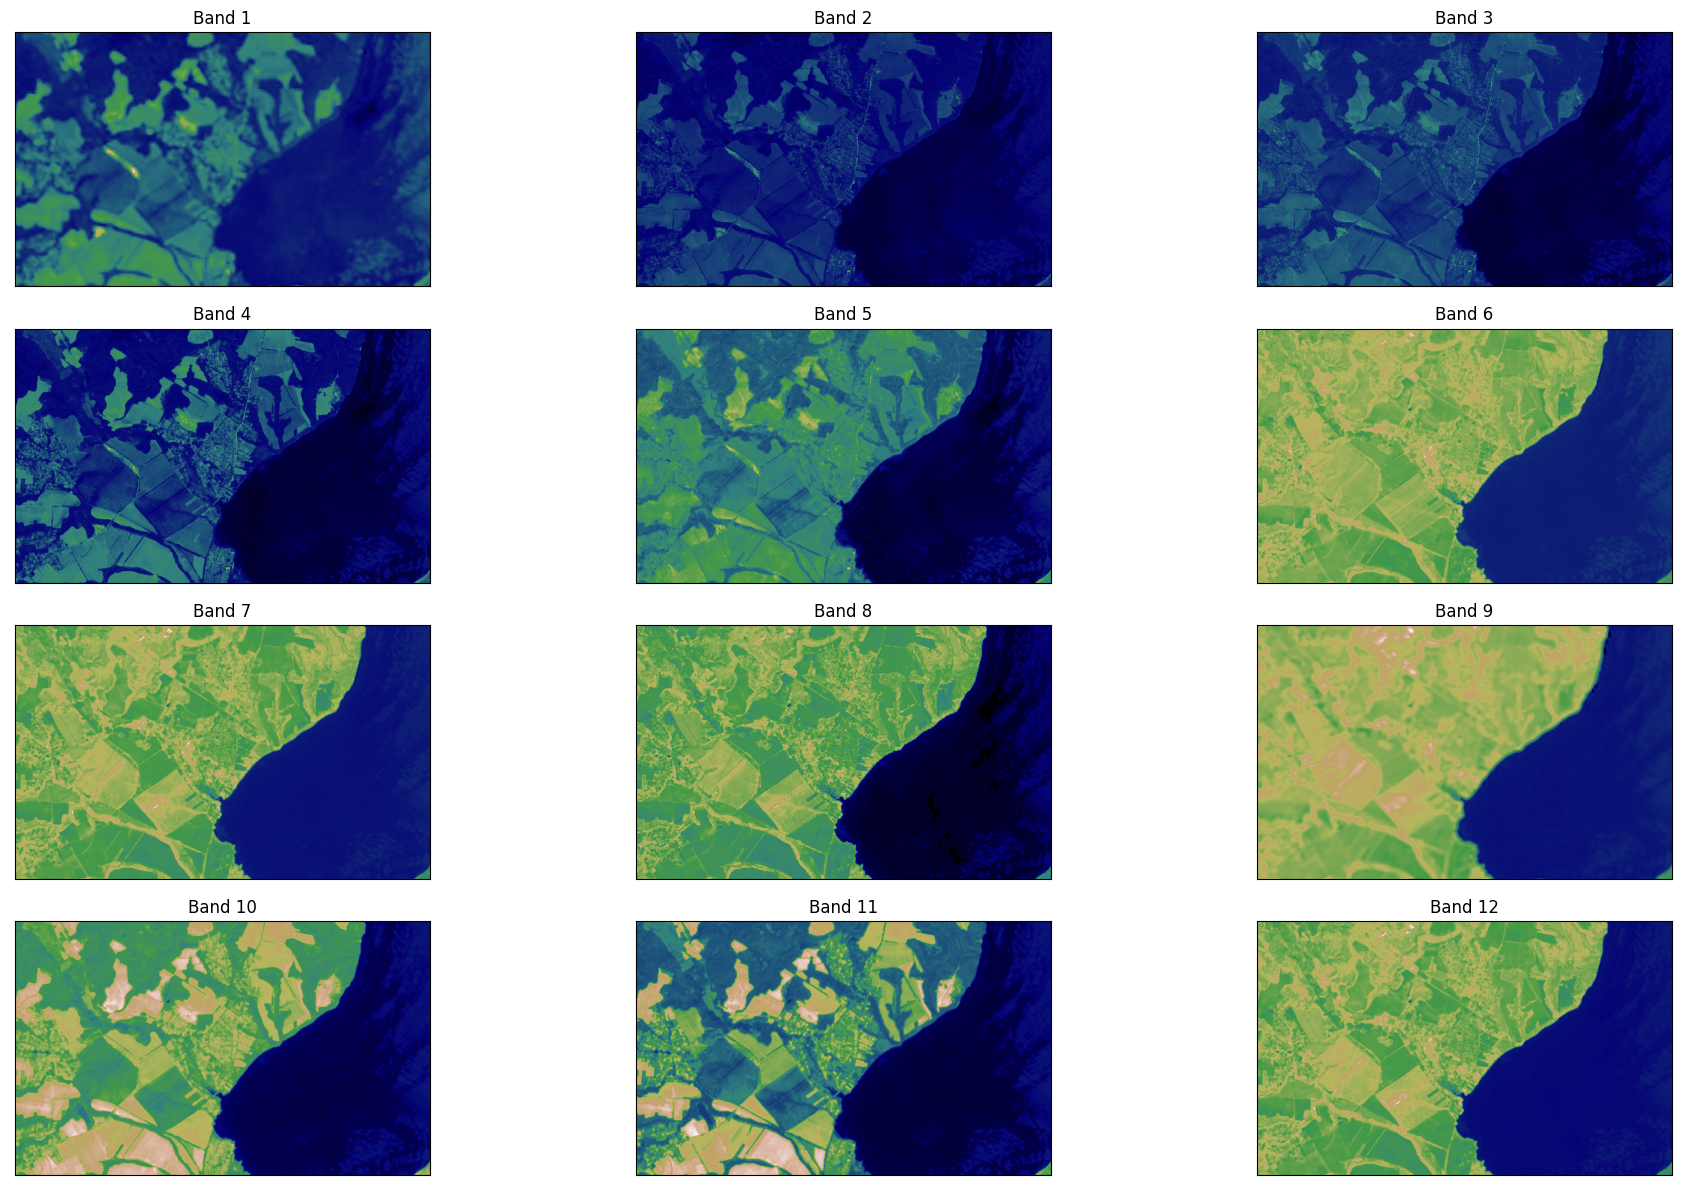

In [7]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 3, cbar = False)
plt.show()

## RGB Composite Image

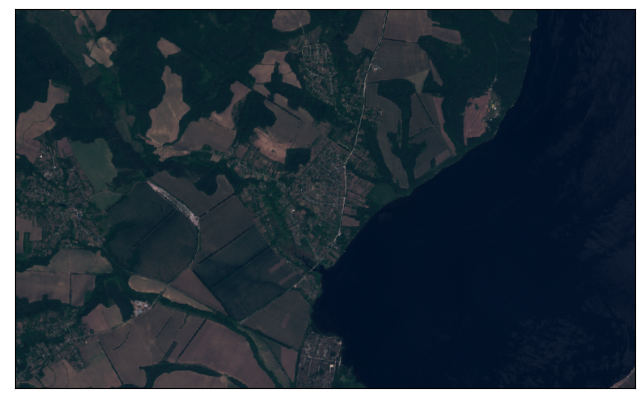

In [8]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

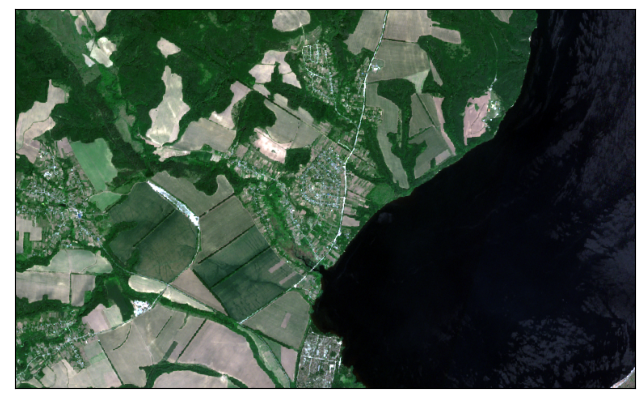

In [9]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Data Distribution of Bands

In [10]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'gray']

ep.hist(arr_st,
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 14)],
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

ValueError: The number of plot titles should be the same as the number of raster layers in your array.

# Preprocessing 

In [11]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(469, 767, 12)

In [12]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(359723, 12)

In [13]:
y_data = loadmat('/tmp/shared/dataset22/matlab.mat')['data']
y_data.shape

(469, 767)

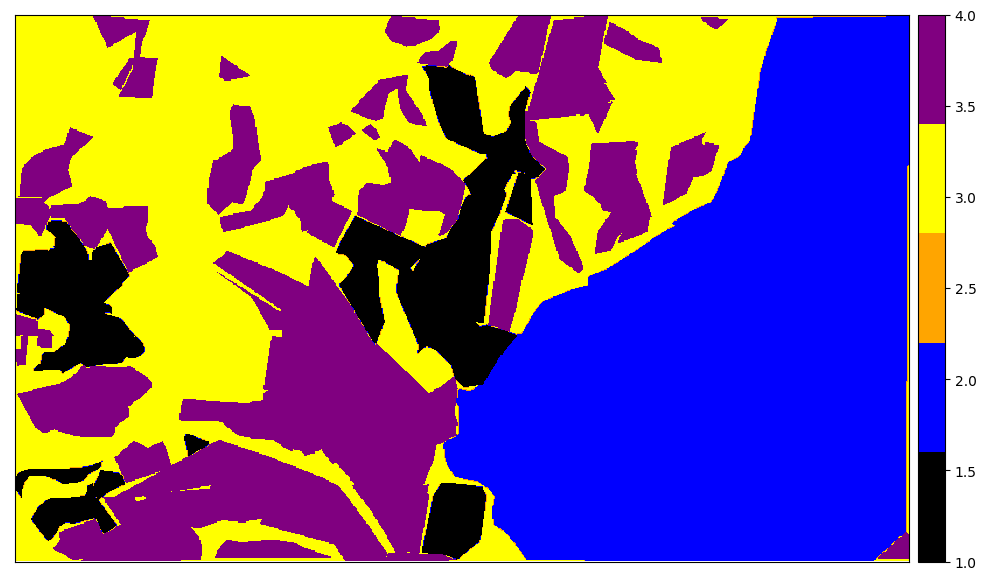

In [14]:
# Visualize Groundtruth

ep.plot_bands(y_data, cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (251806, 12)
X_test Shape: (107917, 12)
y_train Shape: (251806,)
y_test Shape:(107917,)


# K-Nearest Neighbor Classifier (K-NNC)



In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [22]:
import pickle

knnModelFile = "/tmp/shared/knnc.sav"

pickle.dump(knn, open(knnModelFile, 'wb'))

In [23]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 89.06659747769119


In [24]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      9686
           2       0.98      1.00      0.99     36446
           3       0.87      0.86      0.87     35783
           4       0.89      0.86      0.87     26002

    accuracy                           0.89    107917
   macro avg       0.84      0.85      0.85    107917
weighted avg       0.89      0.89      0.89    107917



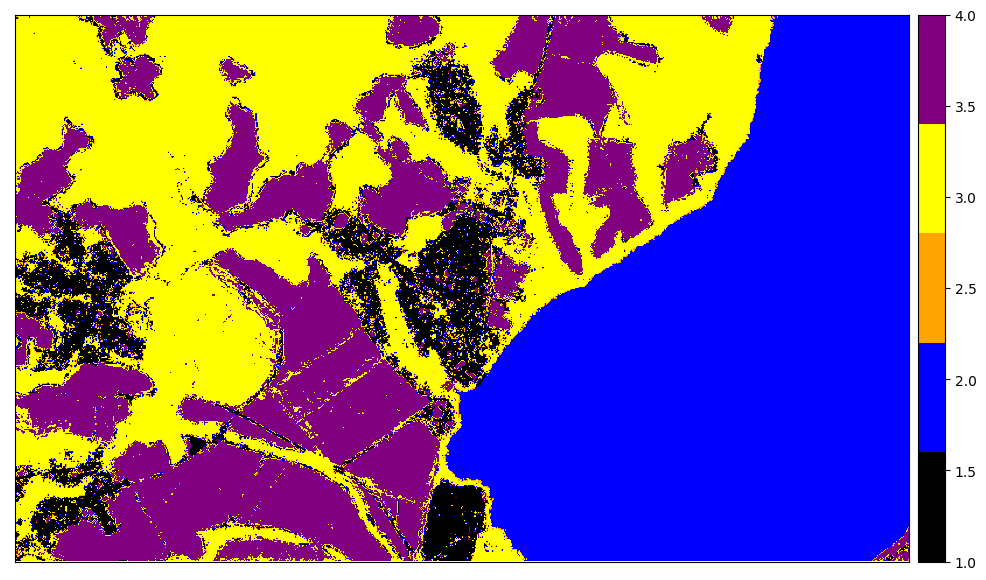

In [25]:
# Visualize Classification Map of K-NNC
knn_image_default = knn.predict(X_scaled).reshape((469, 767))
ep.plot_bands(knn_image_default,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([ 35161.,      0.,      0., 122928.,      0.,      0., 118151.,
             0.,      0.,  83483.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

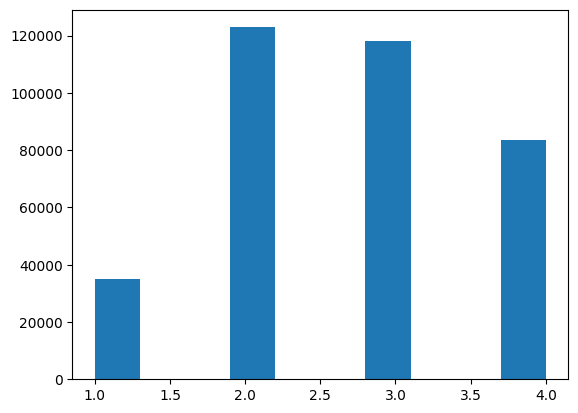

In [46]:
plt.hist(knn_image_default.reshape(-1))

In [26]:
knn_proba = knn.predict_proba(X_scaled)

In [27]:
knn_proba

array([[0.3, 0. , 0.7, 0. ],
       [0.2, 0. , 0.7, 0.1],
       [0.1, 0. , 0.8, 0.1],
       ...,
       [0. , 0. , 0.1, 0.9],
       [0. , 0. , 0.5, 0.5],
       [0.8, 0. , 0.1, 0.1]])

In [28]:
knn_proba1 = knn_proba[: , 0]
knn_proba2 = knn_proba[: , 1]
knn_proba3 = knn_proba[: , 2]
knn_proba4 = knn_proba[: , 3]

(array([220528.,  22849.,  24410.,      0.,   6929.,  10688.,   5386.,
             0.,   6259.,  62674.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

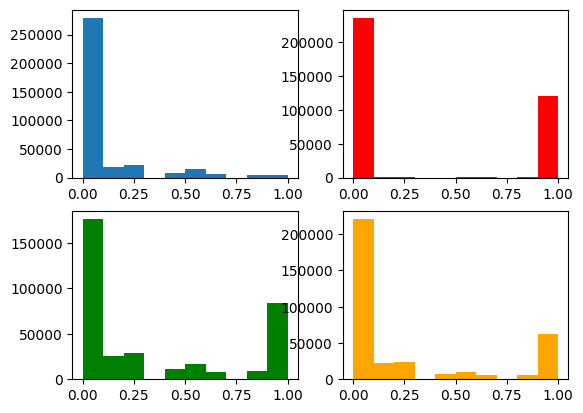

In [29]:
# ep.hist(np.array([knn_proba1, knn_proba2, knn_proba3, knn_proba4]))

# plt.show()
import matplotlib.pyplot as mplt
# mplt.hist(knn_proba4)
fig, axs = mplt.subplots(2, 2)
axs[0,0].hist(knn_proba1)
axs[0,1].hist(knn_proba2, color="red")
axs[1,0].hist(knn_proba3, color="green")
axs[1,1].hist(knn_proba4, color="orange")


# Support Vector Machine (SVM)

In [16]:
from sklearnex import patch_sklearn

patch_sklearn()

from sklearn.svm import SVC
svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=1024)
svm.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVC(C=3.0, cache_size=1024, degree=6)

In [36]:
svmModelFile = "/tmp/shared/svm.sav"

pickle.dump(svm, open(svmModelFile, 'wb'))

In [17]:
svm_pred = svm.predict(X_test)

(array([ 9553.,     0.,     0., 36898.,     0.,     0., 35668.,     0.,
            0., 25798.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

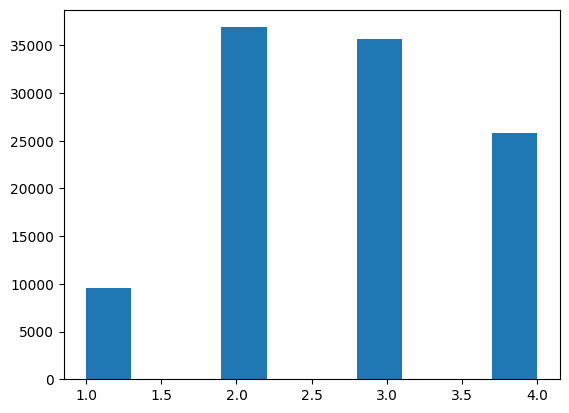

In [18]:
plt.hist(svm_pred)

In [33]:
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")

Accuracy: 88.1455192416394


In [48]:
#svm_proba = svm.predict_proba(X_scaled)

AttributeError: predict_proba is not available when  probability=False

In [34]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           1       0.62      0.62      0.62      9686
           2       0.98      1.00      0.99     36446
           3       0.86      0.85      0.86     35783
           4       0.86      0.86      0.86     26002

    accuracy                           0.88    107917
   macro avg       0.83      0.83      0.83    107917
weighted avg       0.88      0.88      0.88    107917



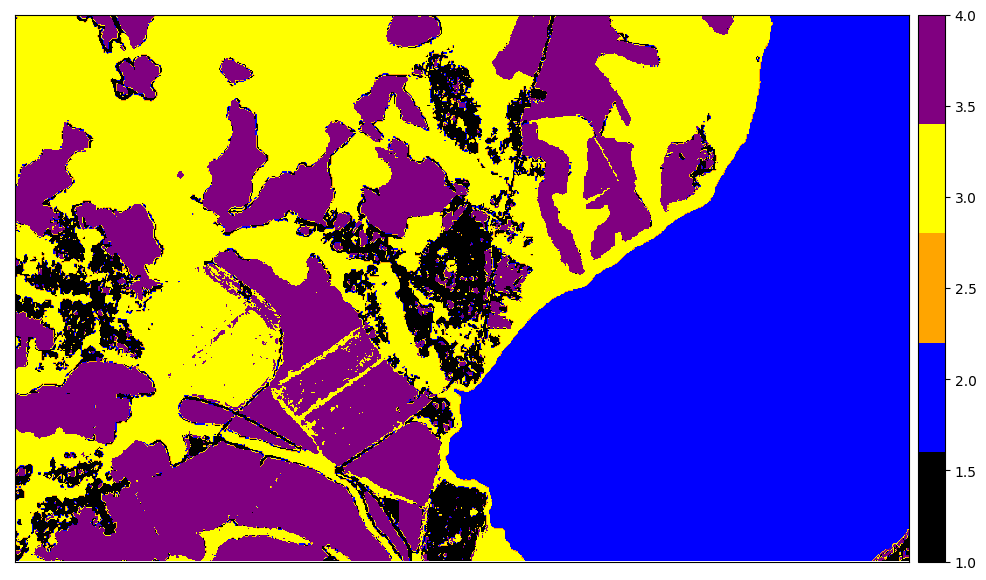

In [35]:
# Visualize Classification Map of SVM
svm_image = svm.predict(X_scaled).reshape((469, 767))
ep.plot_bands(svm_image,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

# Light BGM

In [44]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py:235: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [37]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=6 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 251806, number of used features: 12
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -2.410709
[LightGBM] [Info] Start training from score -1.085525
[LightGBM] [Info] Start training from score -1.103884
[LightGBM] [Info] Start training from score -1.423193
[LightGBM] [Info] Start training from score -34.538776


In [38]:
gbmModelFile = "/tmp/shared/gbm.sav"

pickle.dump(clf, open(gbmModelFile, 'wb'))

In [39]:
lgb_predictions = clf.predict(X_test)

In [40]:
print(lgb_predictions[1], np.argmax(lgb_predictions[1]))

[1.33244024e-16 9.92848683e-04 9.93057100e-01 3.54517081e-03
 2.40488027e-03 1.33244024e-16] 2


In [41]:
# lbg_pred = [np.argmax(x) for x in lgb_predictions]
# np.array(lbg_pred).shape

lgb_pred = np.argmax(lgb_predictions, axis=1)
lgb_pred.shape

(107917,)

In [42]:
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")

Accuracy: 88.34196651130036


In [43]:
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           1       0.62      0.63      0.62      9686
           2       0.98      1.00      0.99     36446
           3       0.87      0.85      0.86     35783
           4       0.86      0.86      0.86     26002

    accuracy                           0.88    107917
   macro avg       0.83      0.84      0.83    107917
weighted avg       0.88      0.88      0.88    107917



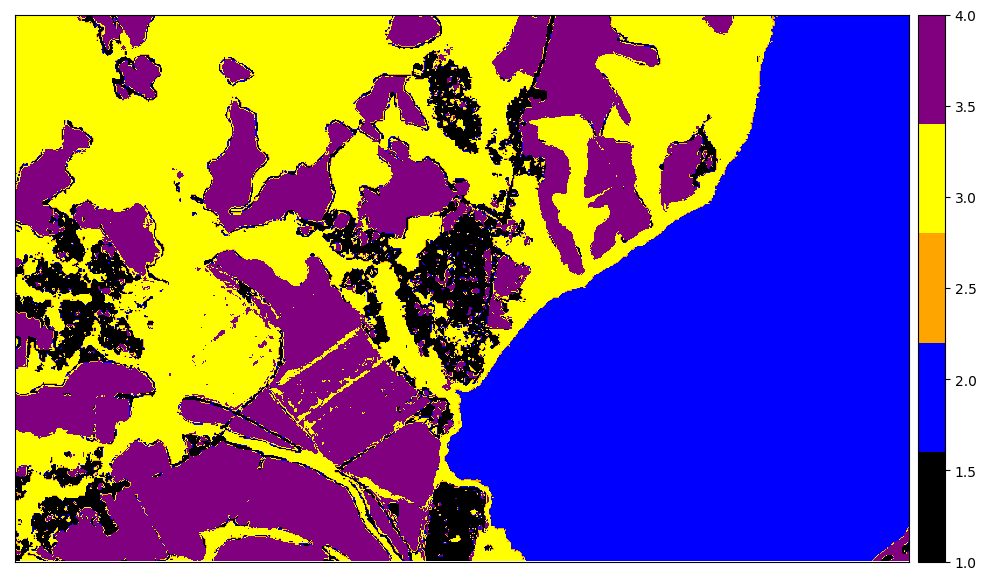

In [44]:
# Visualize Classification Map of LightGBM
gbm_image = np.argmax(clf.predict(X_scaled), axis=1).reshape((469, 767))
ep.plot_bands(gbm_image,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

ep.plot_bands(np.array([knn_image_default, svm_image, gbm_image]),
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']),
              cols=3,
              title=["KNN", "SVM", "GBM"])

## Naive bayess

In [1]:
from sklearn.naive_bayes import GaussianNB

In [19]:
gnb = GaussianNB()
gnb_res = gnb.fit(X_train, y_train)

In [26]:
gnb_pred = gnb.predict(X_test)

In [24]:
import pickle
gnbModelFile = "/tmp/shared/gnb.sav"

pickle.dump(gnb, open(gnbModelFile, 'wb'))

(array([ 9063.,     0.,     0., 37010.,     0.,     0., 35849.,     0.,
            0., 25995.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

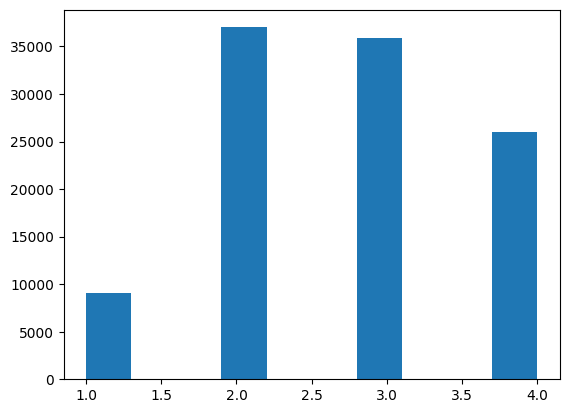

In [27]:
plt.hist(gnb_pred)

In [28]:
print(f"Accuracy: {accuracy_score(y_test, gnb_pred)*100}")

Accuracy: 82.22337537181352


In [29]:
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           1       0.40      0.37      0.38      9686
           2       0.98      1.00      0.99     36446
           3       0.81      0.81      0.81     35783
           4       0.76      0.76      0.76     26002

    accuracy                           0.82    107917
   macro avg       0.74      0.73      0.74    107917
weighted avg       0.82      0.82      0.82    107917



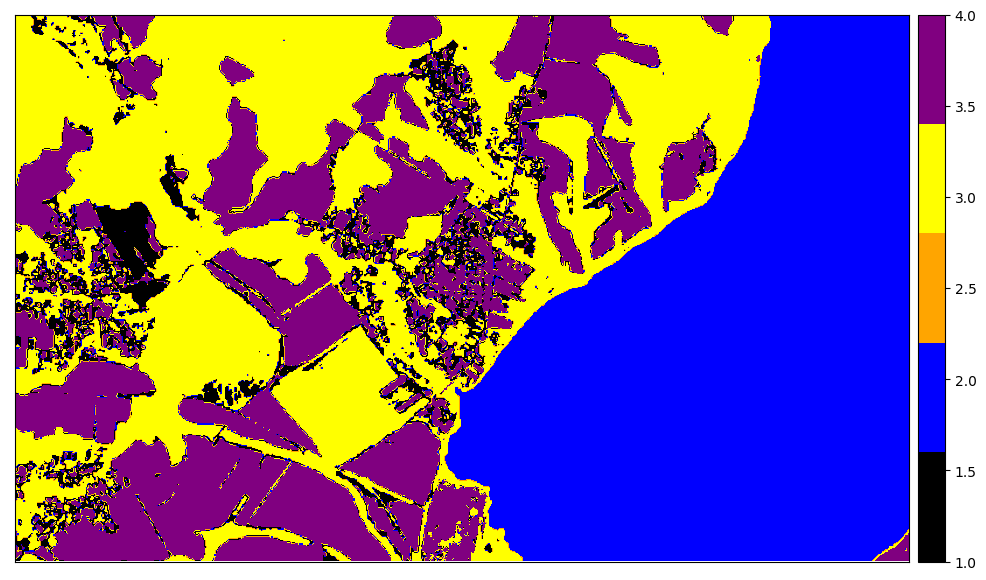

In [30]:
gnb_image = gnb.predict(X_scaled).reshape((469, 767))
ep.plot_bands(gnb_image,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

## Custom image


In [32]:
S_sentinel_bands = glob("/tmp/shared/test_images2/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-

In [33]:
l2 = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l2.append(f.read(1))


In [34]:
arr_st2 = np.stack(l2)

In [35]:
print(f'Height: {arr_st2.shape[1]}\nWidth: {arr_st2.shape[2]}\nBands: {arr_st2.shape[0]}')

Height: 733
Width: 1250
Bands: 12


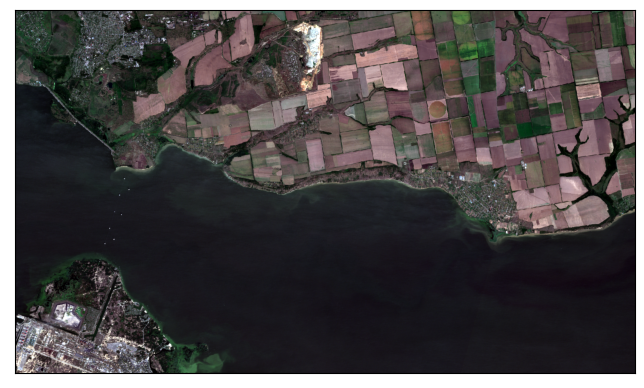

In [36]:
ep.plot_rgb(
    arr_st2,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [37]:
x2 = np.moveaxis(arr_st2, 0, -1)
x2.shape

(733, 1250, 12)

In [38]:
# from sklearn.preprocessing import StandardScaler

X_data2 = x2.reshape(-1, 12)

scaler2 = StandardScaler().fit(X_data2)

X_scaled2 = scaler2.transform(X_data2)

X_scaled2.shape

(916250, 12)

In [39]:
y_data2 = loadmat('/tmp/shared/test_images2/labeling.mat')['data']
y_data2.shape

(733, 1250)

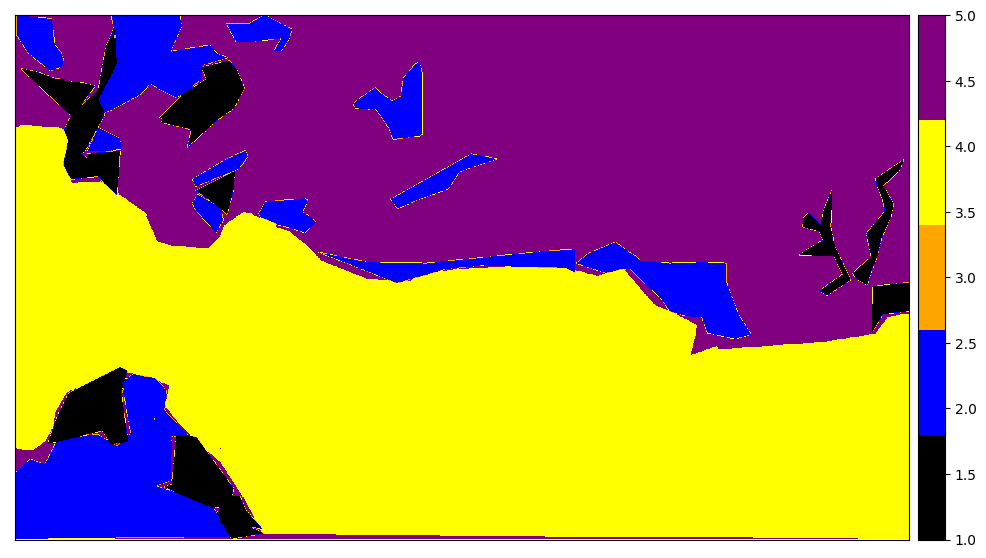

In [40]:
ep.plot_bands(y_data2, cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y_data2.ravel(), test_size=0.30, stratify = y_data2.ravel())

print(f'X_train Shape: {X_train2.shape}\nX_test Shape: {X_test2.shape}\ny_train Shape: {y_train2.shape}\ny_test Shape:{y_test2.shape}')

X_train Shape: (641375, 12)
X_test Shape: (274875, 12)
y_train Shape: (641375,)
y_test Shape:(274875,)


In [61]:
knn_pred2 = knn.predict(X_test2)

In [62]:
print(f"Accuracy: {accuracy_score(y_test2, knn_pred2)*100}")

Accuracy: 14.538244656662119


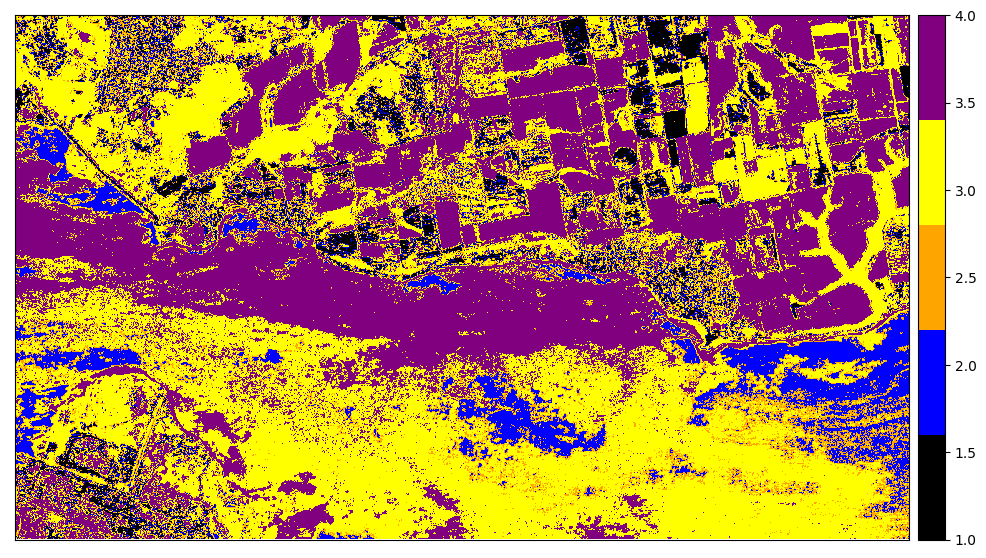

In [64]:
knn_image_default2 = knn.predict(X_scaled2).reshape((733, 1250))
ep.plot_bands(knn_image_default2,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

In [65]:
svm_pred2 = svm.predict(X_test2)

In [66]:
print(f"Accuracy: {accuracy_score(y_test2, svm_pred2)*100}")

Accuracy: 0.6672123692587539


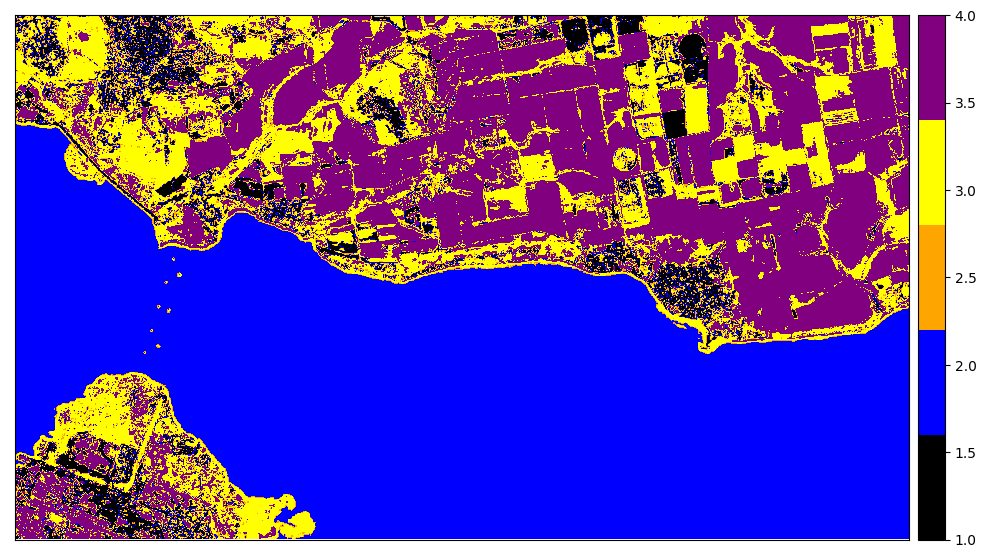

In [67]:
svm_image_default2 = svm.predict(X_scaled2).reshape((733, 1250))
ep.plot_bands(svm_image_default2,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([ 21242.,      0.,      0., 124911.,      0.,      0.,  53285.,
             0.,      0.,  75437.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

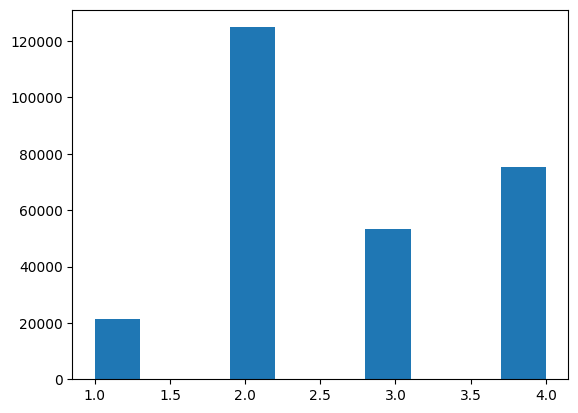

In [68]:
plt.hist(svm_pred2)

In [69]:
svm_pred2_proba = svm.predict_proba(X_test2, probability = True)

AttributeError: predict_proba is not available when  probability=False

In [44]:
gnb_pred2 = gnb.predict(X_scaled2)

(array([112697.,      0.,      0.,   5212.,      0.,      0., 616166.,
             0.,      0., 182175.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

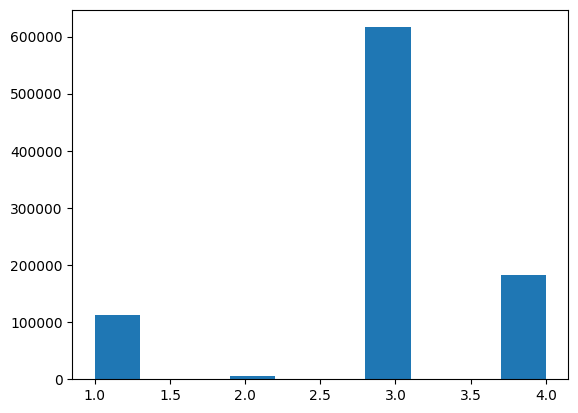

In [45]:
plt.hist(gnb_pred2)

In [47]:
print(f"Accuracy: {accuracy_score(y_data2.ravel(), gnb_pred2)*100}")

Accuracy: 0.22723055934515687


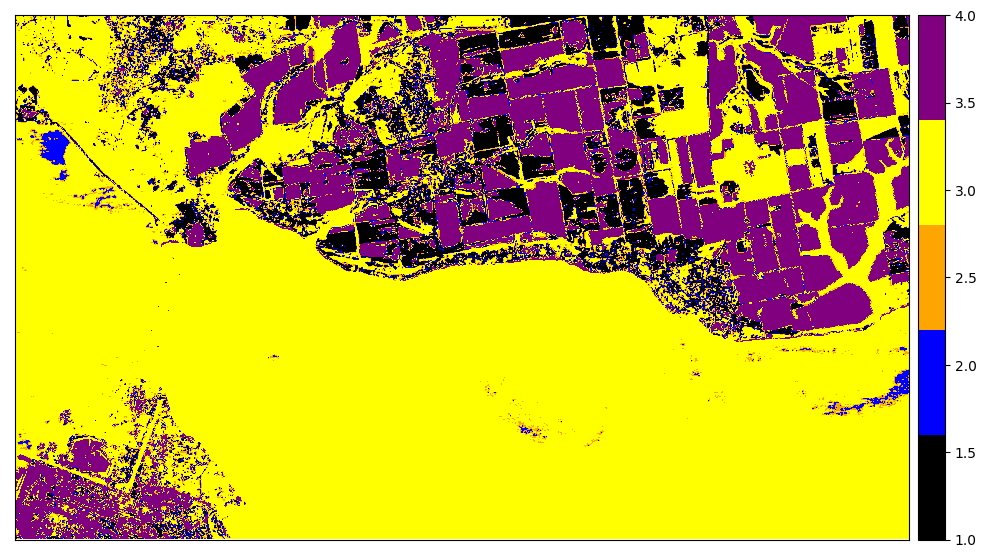

In [48]:
ep.plot_bands(gnb_pred2.reshape((733, 1250)),
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()